---
title: Cancer Detection and Classification
embed-resources: true
echo: false
execute:
  enabled: true
---


## Introduction

In this project, we develop a machine learning model to detect and classify cancer types based on gene expression data collected via next-generation sequencing technologies such as RNA-Seq. Early detection can significantly improve survival and genetic information can help us detect this earlier. Our goal is to build a universal classification and detection model that can predict the cancer type from tissue samples. A model like this can help researchers and clinicians better understand cancer signatures and potentially support diagnostic decision-making in the future.

## Methods
To develop a cancer classification model, we use gene expression data from The Cancer Genome Atlas Pan-Cancer Analysis Project and train machine learning classification models to predict the cancer type from tissue samples.

### Data
Each sample represents a tissue sample from a cancer patient, containing gene expression information. The dataset is split into training and test sets:

* Train: 80% of samples (used for model training and cross-validation)
* Test: 20% of samples (held out for final evaluation)

The underlying source of this data is The Cancer Genome Atlas Pan-Cancer Analysis Project, accessed via synapse.org. The specific data was collected and modified based on a submission to the UCI Irvine Machine Learning Repository. The dataset includes 2000 gene expression features measured by an Illumina HiSeq platform.

### Data Dictionary 

**Response**

* `cancer`: The clinically determined cancer type, one of:
    * `BRCA`: Breast Invasive Carcinoma
    * `PRAD`: Prostate Adenocarcinoma
    * `KIRC`: Kidney Renal Clear Cell Carcinoma
    * `LUAD`: Lung Adenocarcinoma
    * `COAD`: Colon Adenocarcinoma

**Features**

* `gene_####`: Gene expression (for gene number `####` in the dataset) quantification as measured by an Illumina HiSeq platform. There are 2000 gene expression features in total.


In [1]:
import numpy as np
import pandas as pd


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
genetics = pd.read_parquet(
    "https://lab.cs307.org/genetics/data/genetics.parquet",
)

In [3]:
X = genetics.drop("cancer", axis=1)
y = genetics["cancer"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

### Exploratory Data Analysis

The dataset contains tissue samples across five cancer types. We observe class imbalance, with Breast Invasive Carcinoma (BRCA) being the most prevalent class. The gene expression features are continuous numerical values representing expression levels measured via RNA-Seq. No missing values were observed in the dataset.

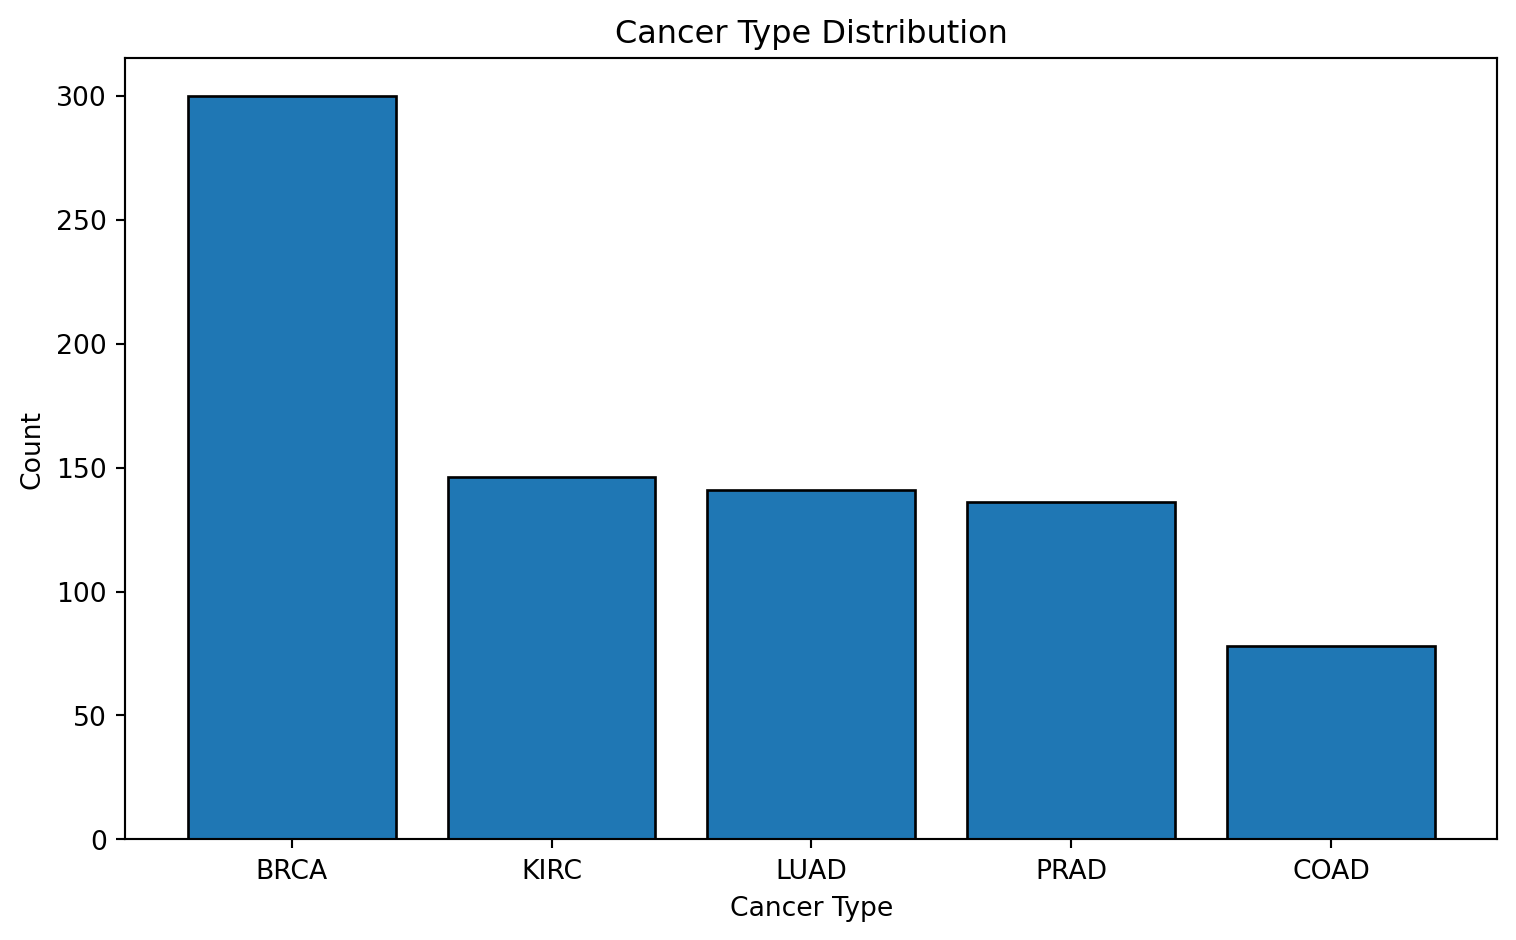

In [4]:
#| label: fig-cancer-distribution
#| fig-cap: "Distribution of cancer types in the dataset. BRCA (Breast Invasive Carcinoma) is the most common class, while COAD (Colon Adenocarcinoma) is the least common."

fig, ax = plt.subplots(figsize=(8, 5))

counts = genetics['cancer'].value_counts()
ax.bar(counts.index, counts.values, edgecolor='black')

ax.set_xlabel('Cancer Type')
ax.set_ylabel('Count')
ax.set_title('Cancer Type Distribution')

plt.tight_layout()
plt.show()

### Model Development

We considered multiple classification approaches to identify the best model for this task:

1. Logistic Regression with Regularization 

2. Random Forest Classifier

3. Histogram Gradient Boosting Classifier

All models were evaluated using 5-fold cross-validation on the training set to select hyperparameters and estimate generalization performance. We used accuracy as the primary metric during tuning.

In [5]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_params = {
    'classifier__C': 1 / (10.0 ** np.arange(-2, 3)),
}

logreg_search = GridSearchCV(
    logreg_pipeline, logreg_params, cv=5, scoring='accuracy'
)
logreg_search.fit(X_train, y_train)
logreg_best = logreg_search.best_estimator_
logreg_cv_score = logreg_search.best_score_

In [6]:
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_features': ['sqrt'],
}

rf_search = GridSearchCV(
    rf_pipeline, rf_params, cv=5, scoring='accuracy'
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
rf_cv_score = rf_search.best_score_

In [7]:
hgb_pipeline = Pipeline([
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

hgb_params = {
    'classifier__learning_rate': [0.1, 0.25],
    'classifier__max_iter': [100],
}

hgb_search = GridSearchCV(
    hgb_pipeline, hgb_params, cv=5, scoring='accuracy'
)
hgb_search.fit(X_train, y_train)
hgb_best = hgb_search.best_estimator_
hgb_cv_score = hgb_search.best_score_

In [8]:
print(f"Logistic Regression: {logreg_cv_score}")
print(f"Random Forest: {rf_cv_score}")
print(f"Histogram Gradient Boosting: {hgb_cv_score}")

Logistic Regression: 0.9984375
Random Forest: 0.9953125
Histogram Gradient Boosting: 0.9953125


In [9]:
models = {
    'Logistic Regression': (logreg_best, logreg_cv_score),
    'Random Forest': (rf_best, rf_cv_score),
    'Histogram Gradient Boosting': (hgb_best, hgb_cv_score)
}

best_model_name = max(models, key=lambda x: models[x][1])
final_model = models[best_model_name][0]
final_model

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(100.0)


We considered models from simple approaches like logistic regression to more flexible methods such as random forests and gradient boosting

## Results

Based on cross-validation performance, the Logistic Regression classifier achieved the highest accuracy and was selected as the final model. We evaluated this model on the held-out test set to obtain unbiased estimates of generalization performance.

In [10]:
y_pred = final_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {test_accuracy}")

Accuracy: 0.9937888198757764


In [11]:
class_names = sorted(y.unique())

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        56
        COAD       1.00      0.94      0.97        17
        KIRC       1.00      1.00      1.00        43
        LUAD       0.95      1.00      0.97        19
        PRAD       1.00      1.00      1.00        26

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



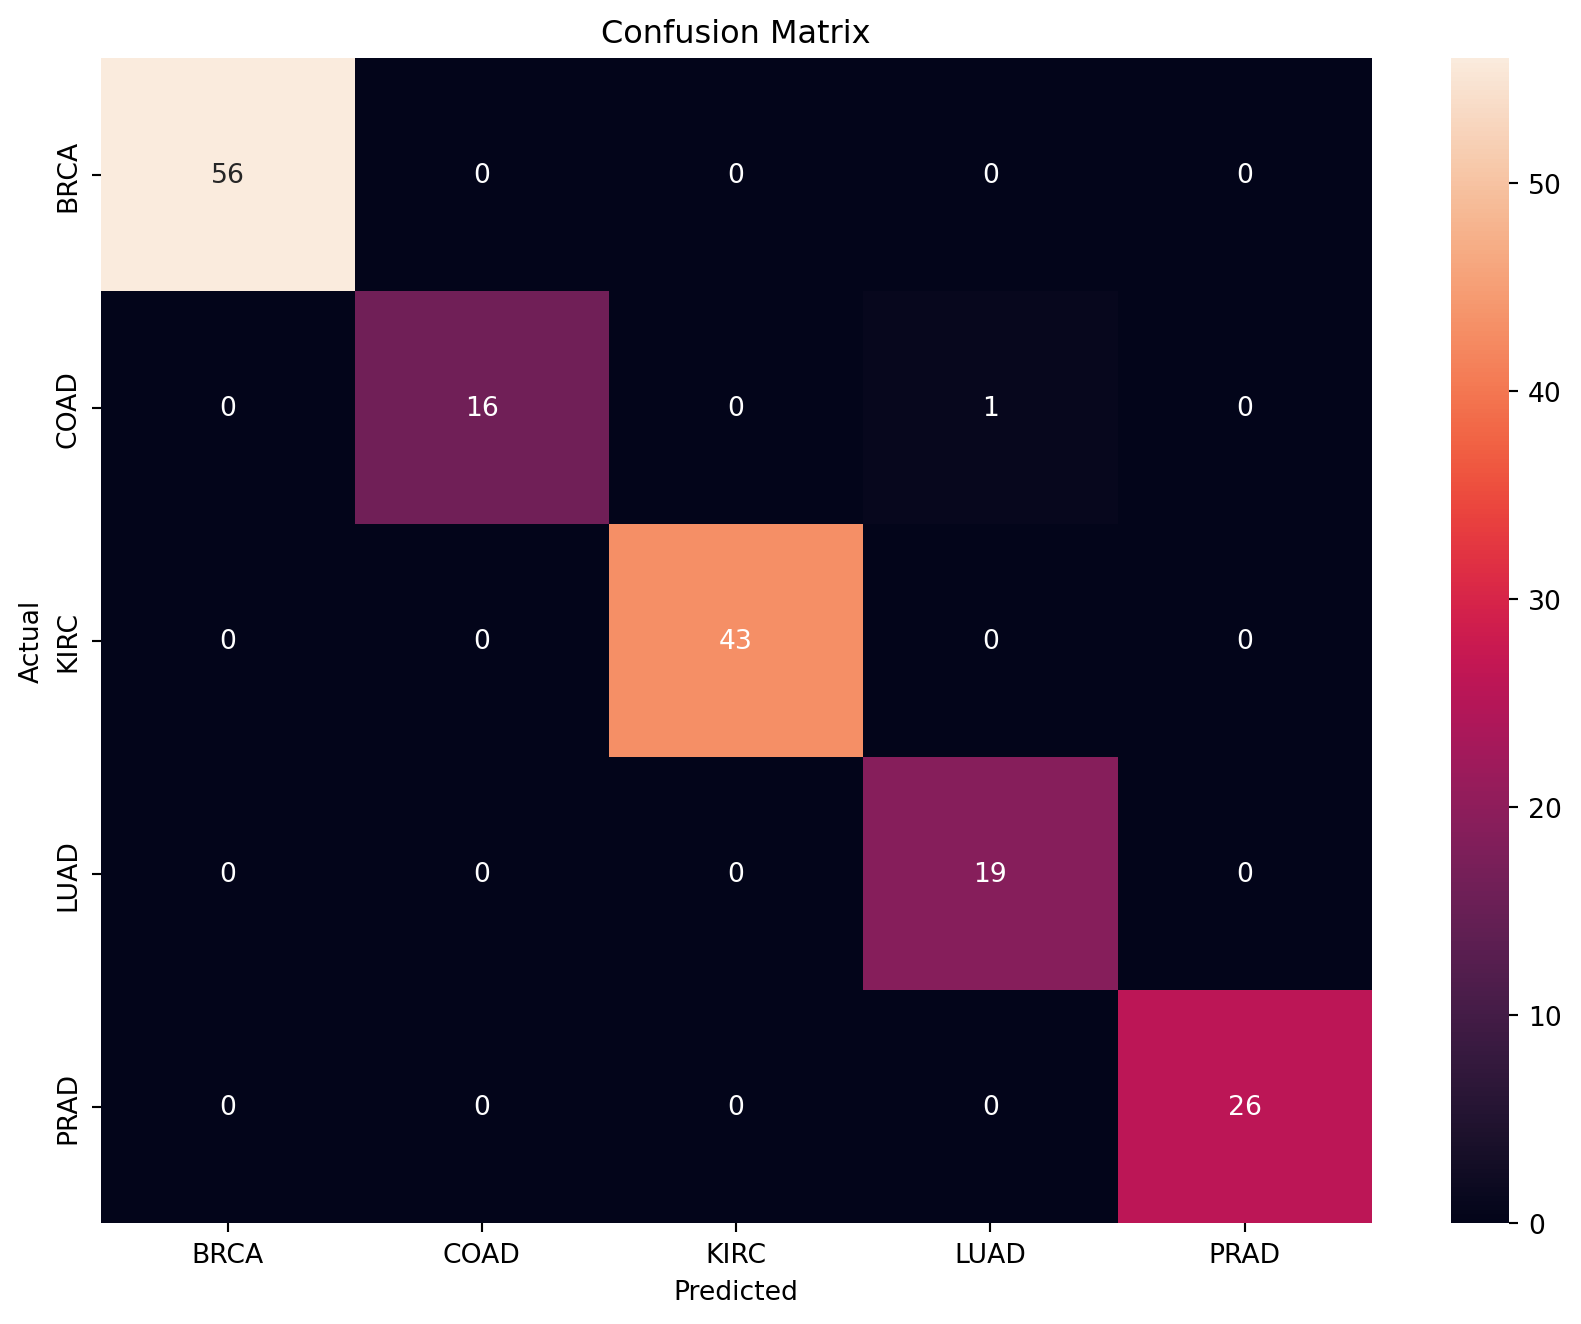

In [12]:
#| label: fig-confusion-matrix
#| fig-cap: "Confusion matrix showing the classification performance across all five cancer types. The diagonal elements represent correct predictions, while off-diagonal elements indicate misclassifications. The model achieves high accuracy across all classes."

fig, ax = plt.subplots(figsize=(9, 7))

cm = confusion_matrix(y_test, y_pred, labels=class_names)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()


## Discussion

The model performs very well on the test data, achieving 100% accuracy. This suggests that gene expression patterns contain strong signals that can be used to distinguish between the cancer types in this dataset. The confusion matrix shows that the few errors that do occur tend to be between biologically similar cancers, which makes sense given that related cancer types can share gene expression characteristics.

### Benefits

* The model shows high performance across all five cancer types, with strong precision and recall for each class
* It relies only on gene expression data, which is commonly available through standard RNA-Seq workflows
* The Random Forest model allows some interpretability through feature importance, offering insight into genes that may be informative
* Cross-validation results are consistent with test results, suggesting stable performance on similar data

### Limitations

* The model is trained on only five cancer types and may not extend to other cancers
* Class imbalance means predictions for smaller groups, such as COAD, may be less reliable 
* The model only differentiates between cancer types and does not identify healthy versus cancerous tissue
* Gene expression measurements can vary across different sequencing platforms and protocols


### Risks

* Incorrect predictions could lead to incorrect follow-up or treatment 
* Misclassifying an aggressive cancer as less aggressive could delay critical treatment
* The model has not been tested on external datasets from different populations or institutions

## Conclusion

We developed a logistic regression model to predict cancer type using gene expression data. The model achieves a test accuracy of 99.38%, suggesting that gene expression profiles has enough information to distinguish between different types of cancer.

I would use this model only as a proof of concept and research tool and not for clinical decision-making right now. However, the performance is impressive supports the idea that gene expression data can be effective for cancer classification, but several important factors should be considered before real-world clinical use

1. The model has not been tested on external datasets from different populations or institutions
2. Misclassifying an aggressive cancer as less aggressive could delay critical treatment
3. The model only classifies among known cancer types and cannot detect new cancers or healthy tissue.
4. Regulatory approval (FDA) would be required before clinical use.

For a biotech startup, this model shows that the idea is workable at a proof-of-concept level. Next steps would include testing it on more cancer types, validating it on external datasets, and adding relevant clinical information to better reflect real-world settings. For now, the model is best suited for research use, such as exploring cancer subtypes or helping identify cases for further study.
